In [32]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [7]:
df = pd.read_csv('HeartAttack.csv')
# Removing column 'group' as it is not required
df = df.drop(columns=['group'])
# Removing rows with any NaN values
df_cleaned = df.dropna()
print(df_cleaned.head(10))

   sub-type  Age  Gender    WBC   RBC   HGB    BA    EO    LY    MO  ...  \
0         2   28       1  10.90  5.09  15.3  0.06  0.19  2.77  0.96  ...   
1         2   40       0   5.96  5.16  15.6  0.03  0.37  2.36  0.43  ...   
2         2   64       1   4.59  5.51  14.9  0.05  0.05  1.12  0.27  ...   
3         2   57       0   7.26  4.70  12.5  0.05  0.11  3.46  0.70  ...   
4         2   58       0   7.15  4.37  12.1  0.03  0.34  1.90  0.47  ...   
5         2   47       1   8.40  4.55  13.4  0.05  0.11  3.60  0.70  ...   
6         2   59       0   4.65  4.99  13.9  0.02  0.10  1.85  0.35  ...   
7         2   63       0   5.59  4.23  11.8  0.01  0.12  1.47  0.37  ...   
8         2   45       1   5.90  5.28  15.0  0.01  0.10  2.40  0.60  ...   
9         2   37       0   8.58  4.57  13.7  0.04  0.12  1.90  0.67  ...   

     MPV  PLT   HCT   MCV  RDW-SD  RDW-CV   MCH  MCHC   PDW    PCT  
0  10.00  309  46.3  91.9    58.0    11.5  30.1  33.0  11.20  0.31  
1  13.30  214  45.9  89.0

In [11]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981 entries, 0 to 980
Data columns (total 25 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   sub-type  981 non-null    int64  
 1   Age       981 non-null    int64  
 2   Gender    981 non-null    int64  
 3   WBC       981 non-null    float64
 4   RBC       981 non-null    float64
 5   HGB       981 non-null    float64
 6   BA        981 non-null    float64
 7   EO        981 non-null    float64
 8   LY        981 non-null    float64
 9   MO        981 non-null    float64
 10  NEU       981 non-null    float64
 11  NEU/LY    981 non-null    float64
 12  PLT/LY    981 non-null    float64
 13  MPV/LY    981 non-null    float64
 14  LY/MO     981 non-null    float64
 15  MPV       981 non-null    float64
 16  PLT       981 non-null    int64  
 17  HCT       981 non-null    float64
 18  MCV       981 non-null    float64
 19  RDW-SD    981 non-null    float64
 20  RDW-CV    981 non-null    float6

# creating the correlation matrix and implementing the PCA in order to reduce the features count

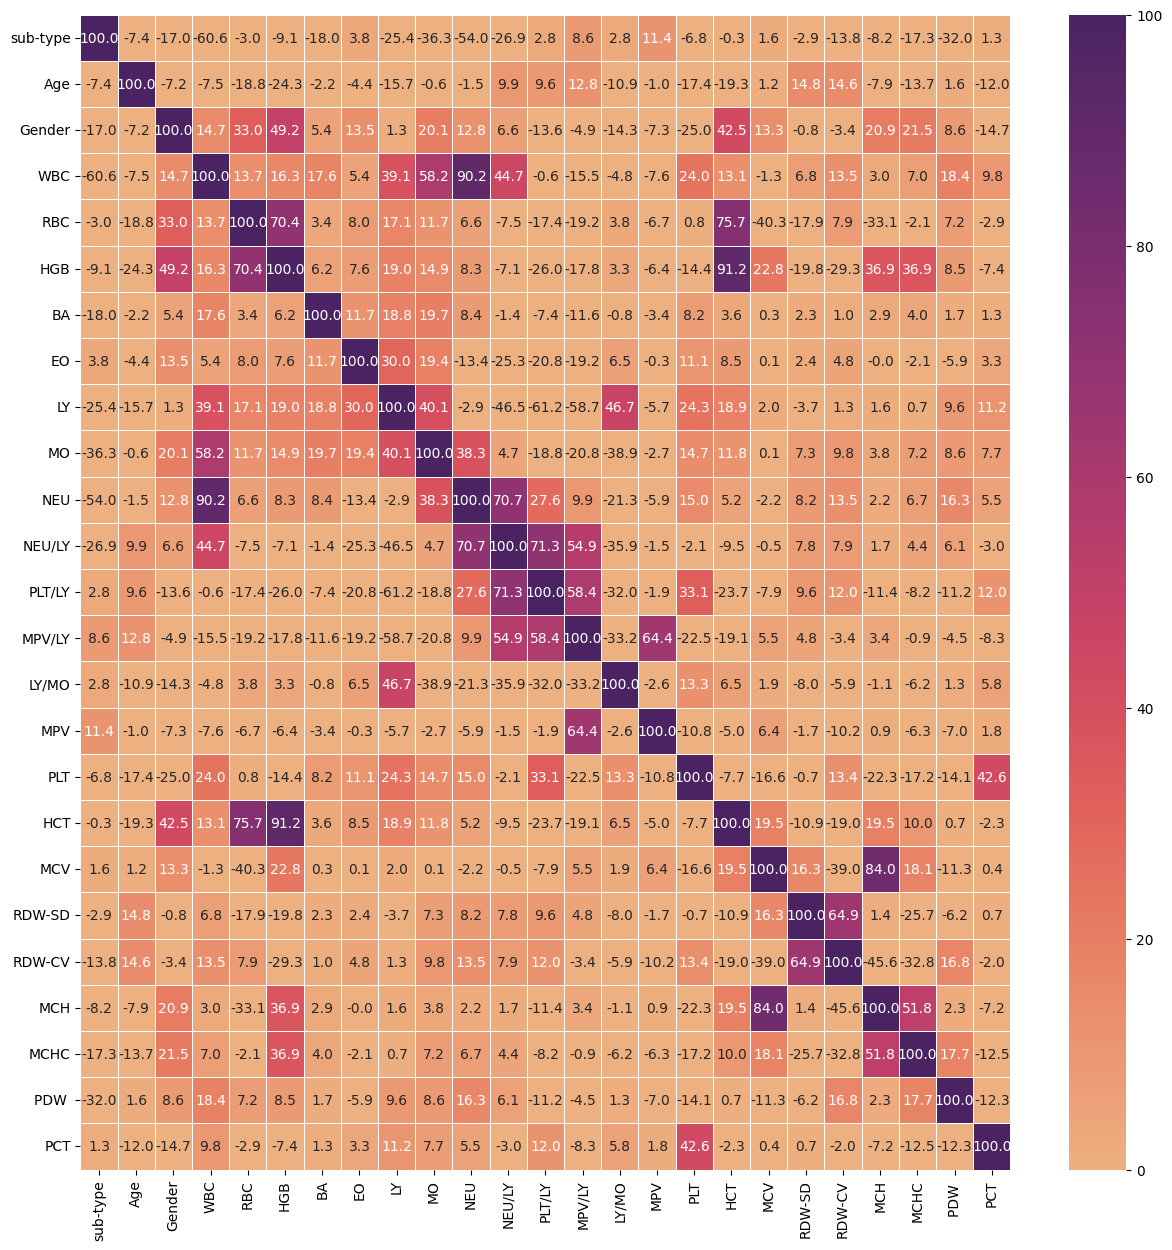

In [10]:

matrix = df_cleaned.corr() * 100

plt.figure(figsize=(15,15))
sns.heatmap(matrix, annot=True, linewidth=.5, vmin=0, vmax=100,
            fmt=".1f", cmap=sns.color_palette("flare", as_cmap=True))
plt.show()

In [19]:
copy_columns = df_cleaned.columns[1:]
X = df_cleaned[copy_columns].copy()
y = df_cleaned['sub-type']


In [20]:
# Scale the data before PCA
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X)
scaled_data_df = pd.DataFrame(scaled_data, columns=X.columns)
scaled_data_df

,Age,Gender,WBC,RBC,HGB,BA,EO,LY,MO,NEU,...,MPV,PLT,HCT,MCV,RDW-SD,RDW-CV,MCH,MCHC,PDW,PCT
0,-2.873600,0.852709,0.565289,0.612289,0.985156,0.060778,0.186459,0.237688,1.150782,0.174486,...,0.052867,0.692371,1.205635,0.923350,3.994687,-1.583841,0.458232,-0.280849,-0.785670,0.409944
1,-1.767169,-1.172733,-0.978413,0.740411,1.175517,-0.416210,1.459656,-0.111359,-0.881921,-1.039192,...,1.009640,-0.643229,1.113795,0.408502,-0.362630,-0.927032,0.500078,0.366685,2.904788,0.188412
2,0.445693,0.852709,-1.406524,1.381022,0.731341,-0.098218,-0.803806,-1.167015,-1.495567,-0.923101,...,0.342799,-0.938467,0.631635,-1.278070,-0.907295,-0.197244,-0.838980,0.366685,0.034432,-0.328497
3,-0.199725,-1.172733,-0.572175,-0.101535,-0.791548,-0.098218,-0.379407,0.825110,0.153607,-0.979387,...,0.052867,0.861079,-0.194926,-0.212867,1.023789,0.824460,-1.843274,-0.863630,-0.546473,0.483788
4,-0.107523,-1.172733,-0.606549,-0.705540,-1.045362,-0.416210,1.247457,-0.502973,-0.728509,-0.462255,...,-0.037011,-0.713524,-0.700047,0.053434,1.518939,1.043396,3.638495,-1.057890,-0.717328,-0.402341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
976,-1.490561,0.852709,0.312172,0.905140,1.175517,-0.416210,-0.379407,0.459035,-0.536745,0.237808,...,-0.382029,-0.010576,0.493875,-0.780975,-0.214085,0.094672,0.290850,1.726507,0.786192,-0.254653
977,-0.107523,0.852709,1.634005,1.069868,0.794795,0.855760,1.035257,0.714436,3.030073,1.191161,...,0.081860,-0.460463,0.585715,-0.124100,-0.907295,-0.416180,-0.378679,0.625699,-0.648986,-0.180809
978,0.261288,0.852709,0.171551,-0.906875,0.096804,-0.098218,-1.086739,-1.413902,-1.035332,0.927318,...,0.313805,-1.247764,-0.355646,1.029870,0.404852,-0.635117,1.504372,1.143726,-0.033910,-0.476185
979,-1.029548,-1.172733,0.749658,-1.291242,-0.728094,1.014756,-0.733073,0.901730,-0.114863,0.554420,...,-0.063105,0.692371,-0.748263,1.136390,-0.362630,-1.218947,0.834842,-0.093064,-1.161549,0.336100


In [27]:
# n_components can also be a percentage indicating the percentage of explained variance you want to capture
pca = PCA(n_components=0.85,random_state=42)
pca_data = pca.fit_transform(scaled_data)
pca_data

array([[ 1.87881236,  1.26246561, -0.19551629, ..., -1.23214976,
        -0.98394095, -1.20283573],
       [ 1.80007253, -1.04028044,  1.59500823, ..., -2.17739013,
        -0.88498747,  0.17870209],
       [-0.5824935 , -0.3179658 ,  1.64737027, ..., -0.26781428,
         0.58675463, -0.10373774],
       ...,
       [-2.31882486,  3.09010982,  3.26146279, ..., -0.36119146,
         0.41469584,  0.16252786],
       [ 0.23790249, -0.67324402,  0.09560597, ...,  0.50704371,
         0.92333382, -0.71113142],
       [-1.25478215, -1.5268964 ,  1.10860276, ...,  0.30894543,
        -0.29620616, -0.31716158]])

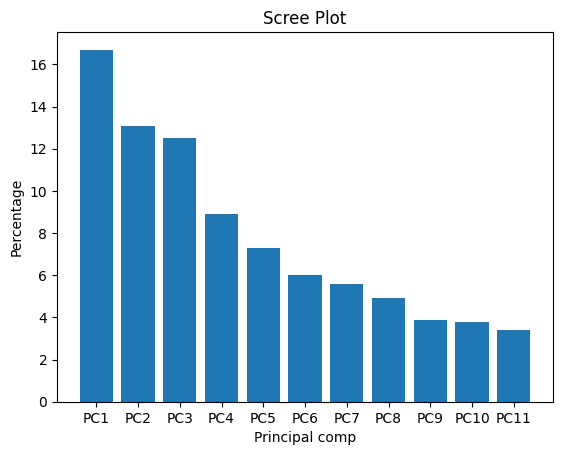

In [28]:
pca.explained_variance_ratio_

# Multiply explained by 100 and round
per_var = np.round(pca.explained_variance_ratio_ * 100, decimals=1)
# Create labels for barplot
labels = ['PC' + str(x) for x in range(1, len(per_var) + 1)]


plt.bar(x=range(1, len(per_var)+1), height=per_var, tick_label=labels)

plt.ylabel('Percentage')

plt.xlabel('Principal comp')

plt.title('Scree Plot')

plt.show()

In [29]:
sum(pca.explained_variance_ratio_)

0.861288827273476

[pca] >Extracting column labels from dataframe.
[pca] >Extracting row labels from dataframe.
[pca] >The PCA reduction is performed to capture [85.0%] explained variance using the [24] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [85.00%] explained variance.
[pca] >The PCA reduction is performed on the [24] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[11]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]


[scatterd] >INFO> Create scatterplot
[scatterd] >INFO> Create scatterplot


[scatterd]> WARNING use the standardized verbose status. The status [1-6] will be deprecated in future versions.
[pca] >Plot PC1 vs PC2 with loadings.
[scatterd]> WARNING use the standardized verbose status. The status [1-6] will be deprecated in future versions.


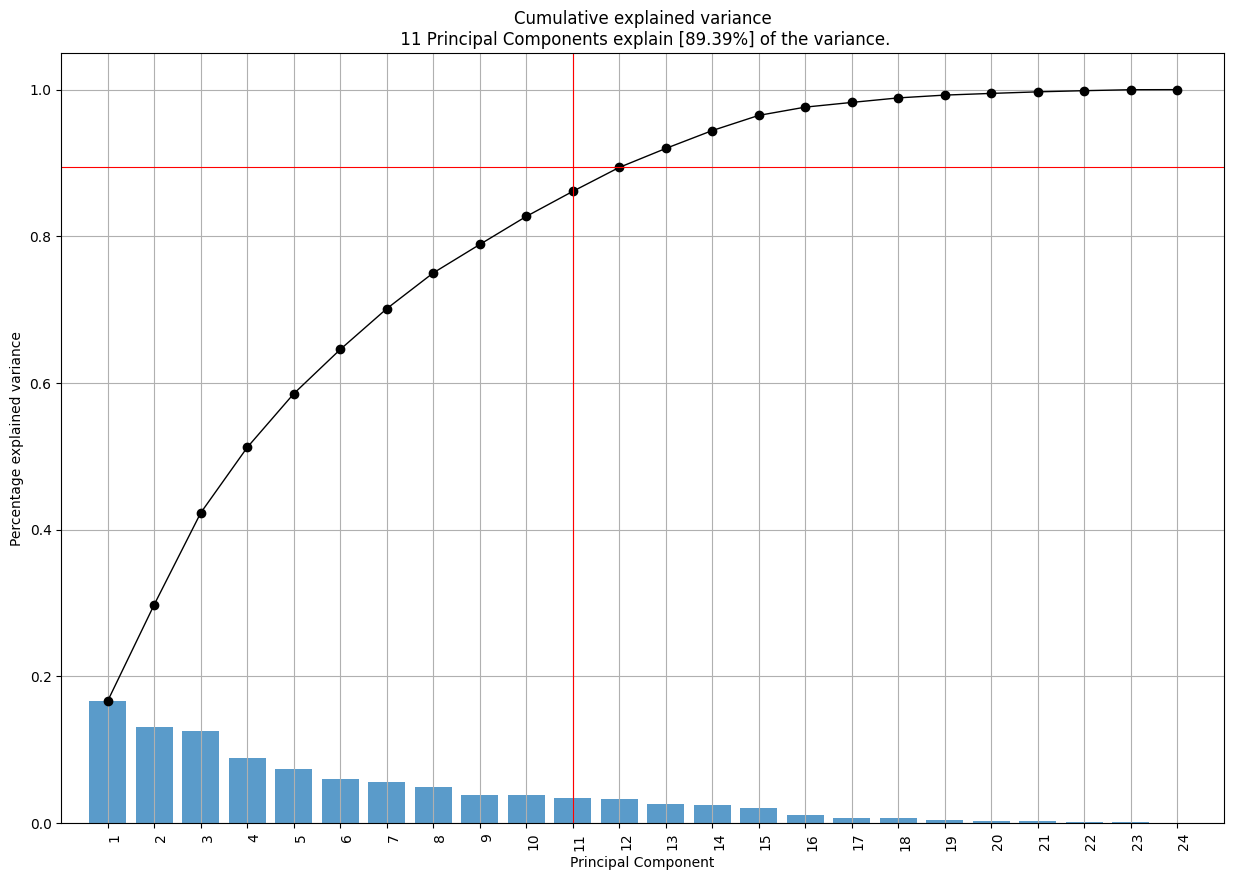

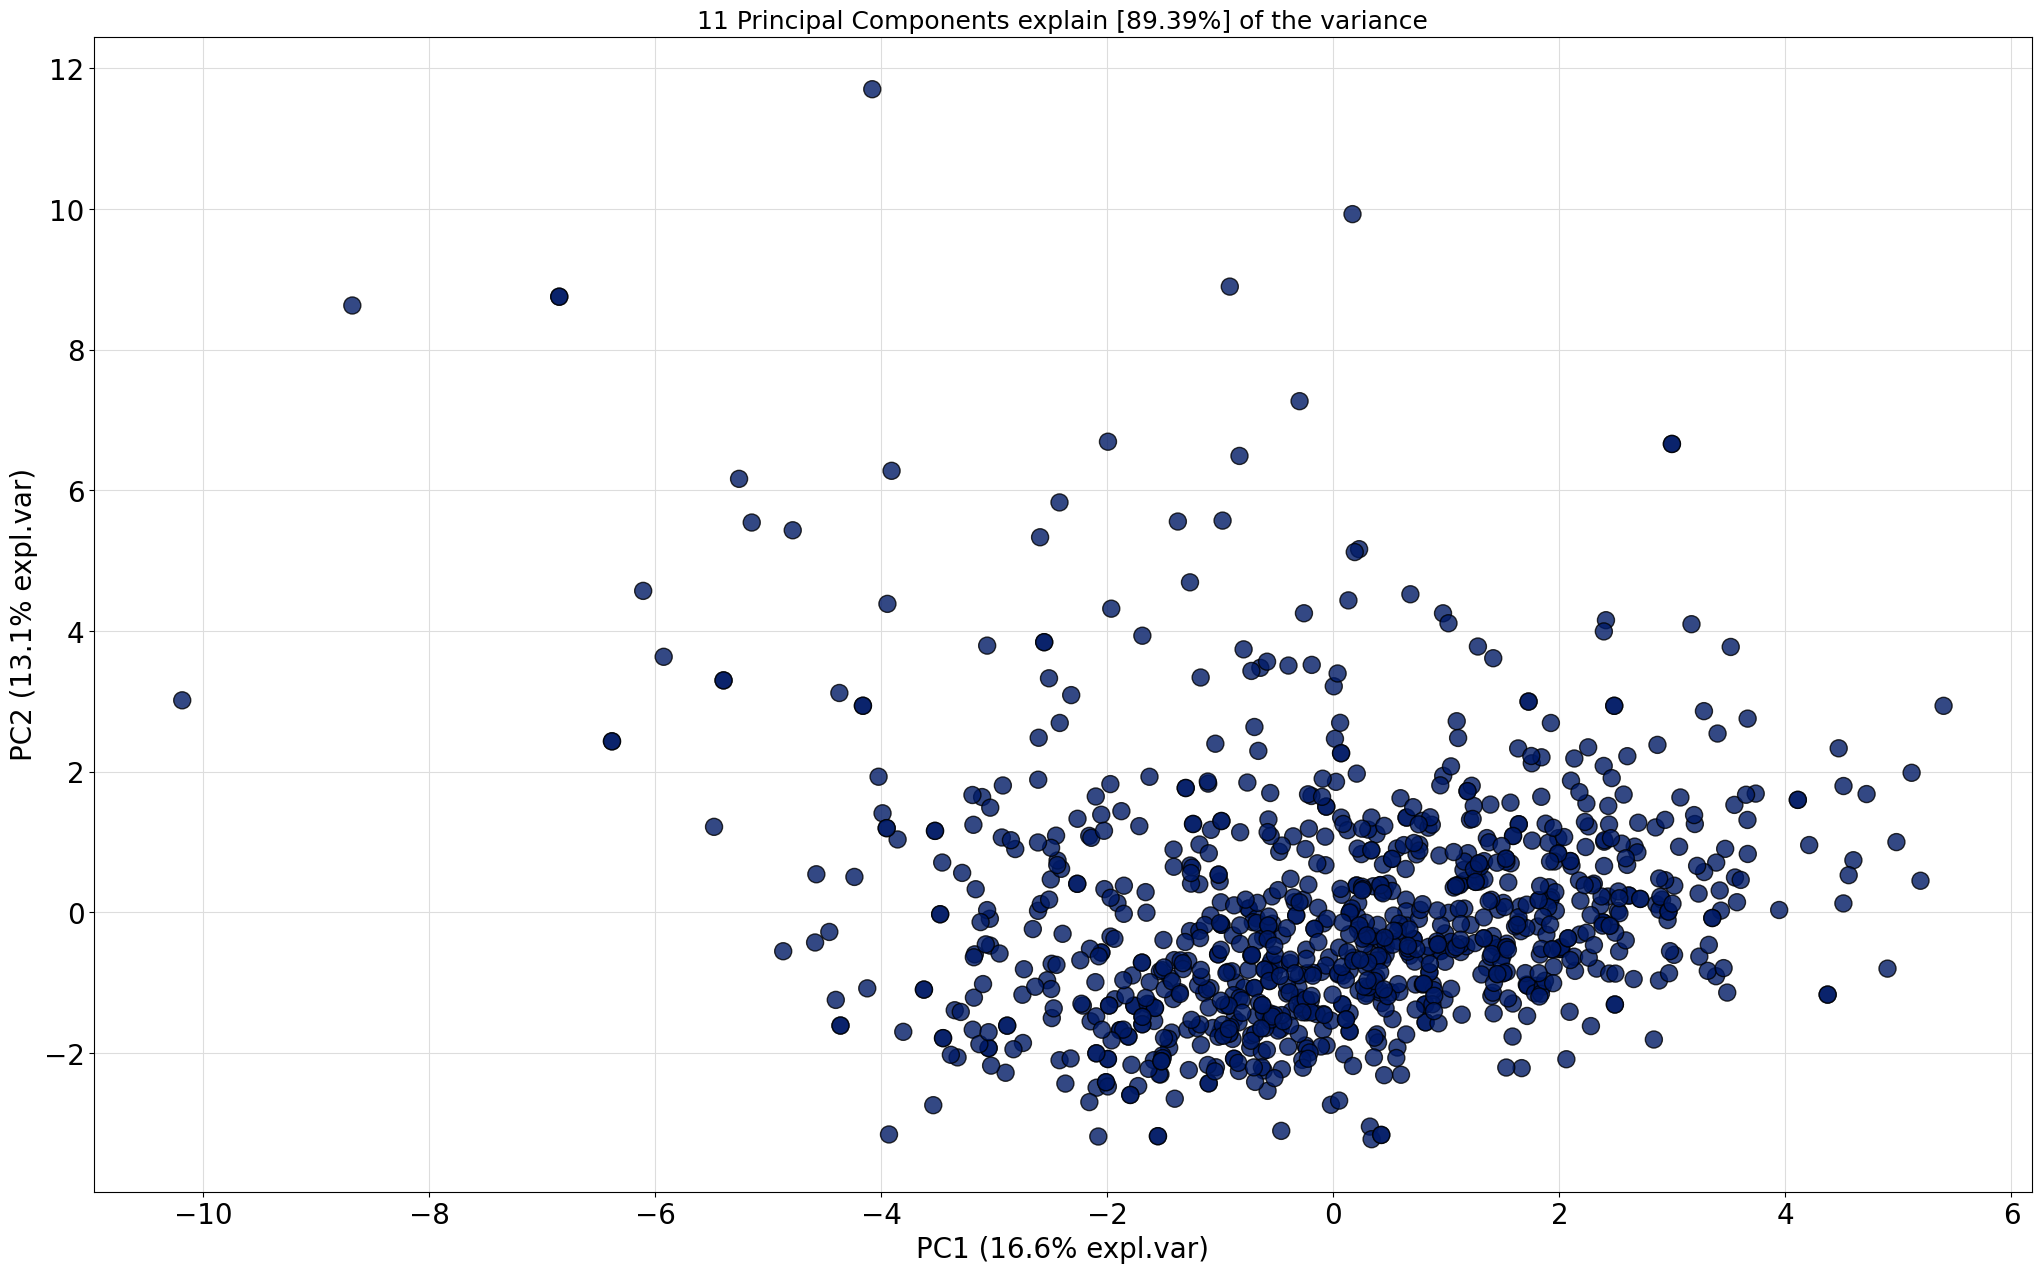

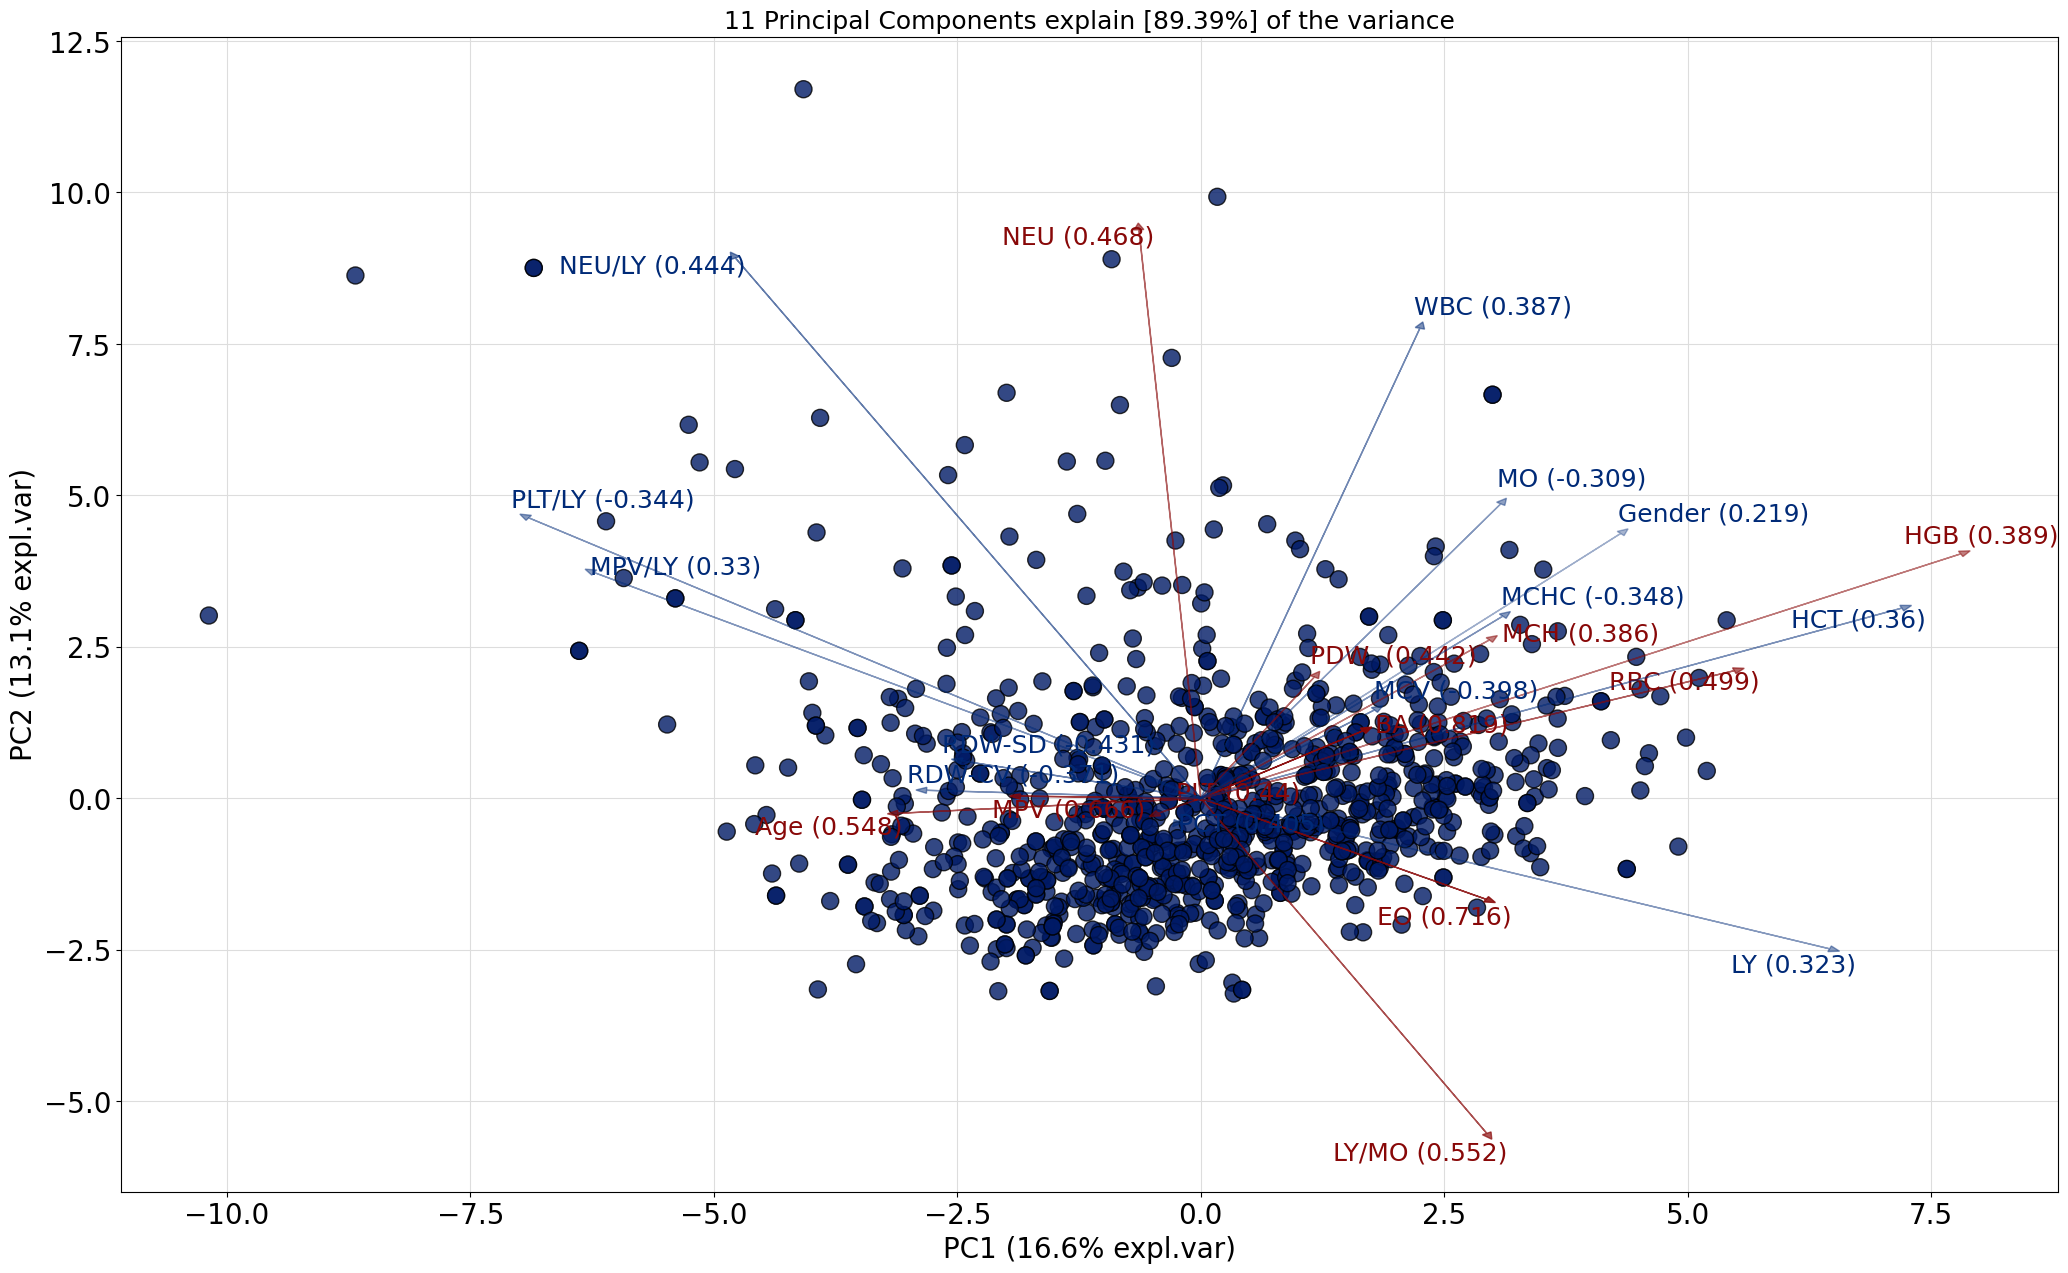

In [30]:
from pca import pca
#scaled_data_df = pd.DataFrame(scaled_data, columns=data.columns)
###########################################################
# COMPUTE AND VISUALIZE PCA
###########################################################
# Initialize the PCA
model = pca(n_components=0.85)

# Fit and transform
results = model.fit_transform(X=scaled_data_df)

# Plot the explained variance
fig, ax = model.plot()

# Scatter the first two PCs
fig, ax = model.scatter()

# Create a biplot
fig, ax = model.biplot()

In [31]:
pca_df = pd.DataFrame(pca_data, columns=labels)
pca_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11
0,1.878812,1.262466,-0.195516,-0.833162,0.172783,-3.102098,-0.954263,0.233902,-1.232150,-0.983941,-1.202836
1,1.800073,-1.040280,1.595008,0.943560,0.523177,0.435807,0.882538,1.438984,-2.177390,-0.884987,0.178702
2,-0.582494,-0.317966,1.647370,3.572777,0.239799,0.340456,0.145956,-0.005258,-0.267814,0.586755,-0.103738
3,-0.615601,-2.246860,-1.988319,0.054678,0.069171,-0.796045,-0.121876,0.305761,0.206137,-0.249142,-0.881842
4,-1.142697,-1.143459,1.153539,-1.775222,-1.416274,-1.394322,-0.865355,0.328994,-0.663004,-0.250010,0.674821
...,...,...,...,...,...,...,...,...,...,...,...
976,2.223478,0.387819,0.128680,0.863519,0.356956,1.294772,-0.579741,0.866430,-1.393134,-0.613676,0.033922
977,2.601523,2.222001,-1.318976,-0.318585,-0.336266,-0.045751,1.846025,-1.695558,0.926157,-0.033310,0.066977
978,-2.318825,3.090110,3.261463,-0.260394,-0.283354,0.150760,-0.322202,0.579047,-0.361191,0.414696,0.162528
979,0.237902,-0.673244,0.095606,-2.856853,1.662890,0.301925,0.063032,0.407092,0.507044,0.923334,-0.711131


In [37]:

# Splitting the data into features and target
X_PCA = pca_df.copy()


# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_PCA, y, test_size=0.2, random_state=42)

# Creating the multinomial logistic regression model
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)

# Fitting the model
model.fit(X_train, y_train)

# Making predictions
y_pred = model.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)
print("Confusion Matrix:\n", conf_matrix)


Accuracy: 0.6649746192893401
Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.43      0.50        37
           1       0.50      0.39      0.44        61
           2       0.75      0.92      0.82        99

    accuracy                           0.66       197
   macro avg       0.61      0.58      0.59       197
weighted avg       0.64      0.66      0.64       197

Confusion Matrix:
 [[16 16  5]
 [11 24 26]
 [ 0  8 91]]


c:\Users\DIPU\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
